<a href="https://colab.research.google.com/github/JaeDoo1034/Kaggle-Study/blob/master/DaconBaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

In [3]:
path = '/content/drive/My Drive/'

In [4]:
zip_file = zipfile.ZipFile(path + '/train.zip')
zip_file.extractall('.')

In [5]:
zip_file = zipfile.ZipFile(path + '/test.zip')
zip_file.extractall('./test/')

In [6]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, concatenate, Input
from tensorflow.keras import Model

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
train_files = glob.glob('/content/train/*.npy')
len(train_files)

62735

In [9]:
def trainGenerator():
    for file in train_files:
        dataset = np.load(file)
        target= dataset[:,:,-1].reshape(120,120,1)
        remove_minus = np.where(target < 0, 0, target)
        feature = dataset[:,:,:4]

        yield (feature, remove_minus)

In [10]:
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([120,120,4]),tf.TensorShape([120,120,1])))
train_dataset = train_dataset.batch(256).prefetch(1)

In [11]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()
image_sample = np.load(train_files[42])

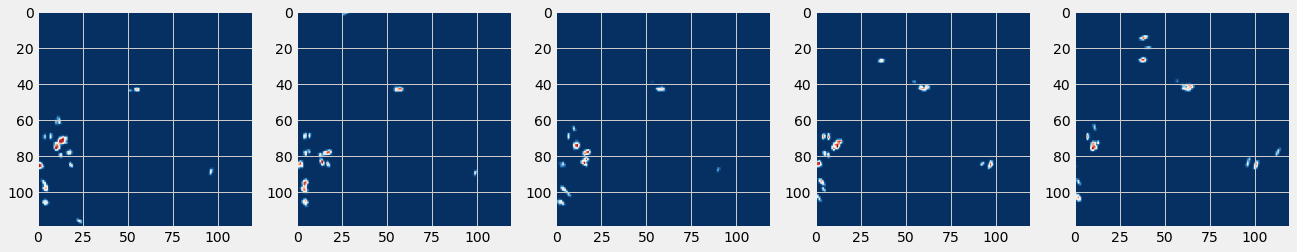

In [12]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 20))

for i in range(4):
    plt.subplot(1,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(1,5,5)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

In [17]:
def base_model(input_layer, start_neurons):
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)

    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((120, 120, 4))
output_layer = base_model(input_layer,32)

In [18]:
input_layer

<tf.Tensor 'input_2:0' shape=(None, 120, 120, 4) dtype=float32>

In [19]:
model = Model(input_layer, output_layer)
model.compile(loss='mae', optimizer='adam')
model.fit(train_dataset, epochs = 5, verbose=1)

Epoch 1/5
      2/Unknown - 1s 498ms/step - loss: 12.8442WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3398s vs `on_train_batch_end` time: 0.6421s). Check your callbacks.
246/246 [==============================] - 244s 992ms/step - loss: 9.9909
Epoch 2/5
246/246 [==============================] - 244s 992ms/step - loss: 4.8980
Epoch 3/5
246/246 [==============================] - 244s 991ms/step - loss: 3.2173
Epoch 4/5
246/246 [==============================] - 244s 991ms/step - loss: 3.1389
Epoch 5/5
246/246 [==============================] - 244s 991ms/step - loss: 3.1017


In [20]:
test_path = '/content/test'
test_files = sorted(glob.glob(test_path + '/*.npy'))

X_test = []

for file in tqdm(test_files, desc = 'test'):
    data = np.load(file)
    X_test.append(data)

X_test = np.array(X_test)

test: 100%|██████████| 2674/2674 [00:04<00:00, 592.88it/s]


In [21]:
X_test.shape

(2674, 120, 120, 4)

In [22]:
pred = model.predict(X_test)

In [23]:
submission = pd.read_csv('/content/drive/My Drive/sample_submission.csv')

In [24]:
submission.iloc[:,1:] = pred.reshape(-1, 14400).astype(int)
submission.to_csv(path + 'Dacon_baseline.csv', index = False)